In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import sent_tokenize
np.random.seed(125)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Dataset Preview

In [14]:
dic = {'FAKE':1,'REAL':0}
df = pd.read_csv('drive/My Drive/CSV/fake_or_real_news.csv')[['title','text','label']]
df['label'] = df['label'].apply(lambda x: dic[x])
df['sent_c'] = df['text'].astype(str).apply(sent_tokenize).apply(len)
df.head()

,title,text,label,sent_c
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,87
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,26
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,16
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,17
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,21


In [15]:
df['label'].value_counts()

0    3171
1    3164
Name: label, dtype: int64

## **Embeddings from google sentence encoder**

In [0]:
# Functions
def convert_to_one_hot(Y, C):
  Y = np.eye(C)[Y.reshape(-1)]
  return Y

# for padding
def fix(arr,pad_s = 50):
  dif = pad_s - arr.shape[0]
  temp = np.concatenate((arr, np.zeros((dif,512))))
  return temp

def acc_plot(history):
  # summarize history for accuracy
  print('========='*10)
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def loss_plot(history):
  # summarize history for loss
  print('========='*10)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


In [17]:
# Article Embeddings made from Google Universal Sentence Encoder
real_art = np.load('drive/My Drive/CSV/emb/GM/gm_real_art_emb.npy')
fake_art = np.load('drive/My Drive/CSV/emb/GM/gm_fake_art_emb.npy')
data = np.concatenate((real_art,fake_art),axis=0)
print('Type\tCounts\n{}\t{}\n{}\t{}'.format('Real',len(real_art),'Fake',len(fake_art)))

Type	Counts
Real	1900
Fake	1992


In [18]:
# Contains Total of 12400 articles 
# Each article has maximum of 50 Sentences (which are padded if less)
# Each sentence is represented by a vector of size (512,) 
data.shape

(3892, 50, 512)

In [25]:
real_art[-1]

array([[ 0.00272507,  0.01960489, -0.00197567, ...,  0.02693786,
        -0.03068938, -0.05358364],
       [-0.00563453,  0.02368031, -0.01412359, ...,  0.01552972,
        -0.07706973, -0.05728036],
       [-0.06520706,  0.02270758, -0.04134183, ...,  0.08438758,
        -0.07415032, -0.02624823],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [27]:
# One hot representation of Labels
Y = convert_to_one_hot(np.append(np.zeros((1900,),dtype=int),np.ones((1992,),dtype=int)),2) # reliable [1,0] fake [0,1]
print(Y[0],Y[2200],sep='\n')

[1. 0.]
[0. 1.]


### **Train - Test**

In [0]:
# Train Test
xTrain, xTest, yTrain, yTest = train_test_split(data, Y, test_size = 0.2, random_state = 125)

In [29]:

# First 5 labels 
yTest[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [30]:
print("Train Size - {}, Test size - {} ".format(yTrain.shape[0],yTest.shape[0]))

Train Size - 3113, Test size - 779 


In [31]:
xTrain.shape

(3113, 50, 512)

In [32]:
unique, counts = np.unique(yTest[:,0], return_counts=True)
unique, counts

(array([0., 1.]), array([379, 400]))

In [0]:
# Will be used in callbacks in keras model.fit
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

## **Model v1**
Simple Single Layer LSTM followed by a dense layer.
- LSTM layer takes input a 3d vector which has 50 timesteps, 512 Features, 1 or more samples
- LSTM layer is the input layer in this case
- Embeddings are directly fed into it.

In [47]:
modelv1 = Sequential()
modelv1.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv1.add(Dropout(0.5))
modelv1.add(Dense(2, activation='softmax'))
modelv1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelv1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 787,970
Trainable params: 787,970
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
history_v1 = modelv1.fit(xTrain, yTrain, epochs=10, validation_data=(xTest, yTest), batch_size=64,validation_split=0.2, callbacks = [es])

Train on 3113 samples, validate on 779 samples
Epoch 1/10
3113/3113 [==============================] - 10s 3ms/step - loss: 0.5386 - acc: 0.7732 - val_loss: 0.4667 - val_acc: 0.8087
Epoch 2/10
3113/3113 [==============================] - 8s 3ms/step - loss: 0.3908 - acc: 0.8571 - val_loss: 0.4207 - val_acc: 0.8421
Epoch 3/10
3113/3113 [==============================] - 8s 3ms/step - loss: 0.3624 - acc: 0.8741 - val_loss: 0.4261 - val_acc: 0.8241
Epoch 4/10
3113/3113 [==============================] - 8s 3ms/step - loss: 0.3332 - acc: 0.8844 - val_loss: 0.4004 - val_acc: 0.8819
Epoch 5/10
3113/3113 [==============================] - 8s 3ms/step - loss: 0.3247 - acc: 0.8879 - val_loss: 0.3597 - val_acc: 0.8691
Epoch 6/10
3113/3113 [==============================] - 8s 3ms/step - loss: 0.3159 - acc: 0.8850 - val_loss: 0.3605 - val_acc: 0.8768
Epoch 7/10
3113/3113 [==============================] - 8s 3ms/step - loss: 0.3031 - acc: 0.8940 - val_loss: 0.3524 - val_acc: 0.8729
Epoch 8/10
311

In [49]:
loss, acc = modelv1.evaluate(xTest, yTest)
print()
print('Test accuracy : {}\nLoss : {}'.format(acc,loss))

779/779 [==============================] - 2s 2ms/step

Test accuracy : 0.8754813862397827
Loss : 0.31578300417005173


## **Model v2**
- Double layered LSTM with dropout and dense.


In [50]:
# MODEl v2
# Change number of units in LSTM 
modelv2 = Sequential()
modelv2.add(LSTM(256, input_shape=(50, 512), return_sequences=True))
modelv2.add(Dropout(0.5)) # change to see different results
modelv2.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv2.add(Dropout(0.5))
modelv2.add(Dense(2, activation='softmax')) # check softmax or other function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
#adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
modelv2.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(modelv2.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 256)           787456    
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 1,313,282
Trainable params: 1,313,282
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
%%time
historyv2 = modelv2.fit(xTrain, yTrain, epochs=10, validation_data=(xTest, yTest), validation_split=0.2, batch_size=64)

Train on 3113 samples, validate on 779 samples
Epoch 1/10
3113/3113 [==============================] - 18s 6ms/step - loss: 0.5135 - acc: 0.7925 - val_loss: 0.4051 - val_acc: 0.8626
Epoch 2/10
3113/3113 [==============================] - 16s 5ms/step - loss: 0.3908 - acc: 0.8651 - val_loss: 0.3934 - val_acc: 0.8562
Epoch 3/10
3113/3113 [==============================] - 16s 5ms/step - loss: 0.3498 - acc: 0.8766 - val_loss: 0.3535 - val_acc: 0.8780
Epoch 4/10
3113/3113 [==============================] - 16s 5ms/step - loss: 0.3458 - acc: 0.8815 - val_loss: 0.3648 - val_acc: 0.8819
Epoch 5/10
3113/3113 [==============================] - 16s 5ms/step - loss: 0.3331 - acc: 0.8837 - val_loss: 0.3673 - val_acc: 0.8716
Epoch 6/10
3113/3113 [==============================] - 16s 5ms/step - loss: 0.3202 - acc: 0.8905 - val_loss: 0.3926 - val_acc: 0.8306
Epoch 7/10
3113/3113 [==============================] - 16s 5ms/step - loss: 0.3186 - acc: 0.8844 - val_loss: 0.4464 - val_acc: 0.8344
Epoch 8/

In [52]:
loss, acc = modelv2.evaluate(xTest, yTest)
print()
print('Test Accuracy : {}\nLoss : {}'.format(acc,loss))

779/779 [==============================] - 3s 4ms/step

Test Accuracy : 0.8947368419522346
Loss : 0.2834716303051666


## **Model v3**
- Added conv layer on top of LSTM stack. layer 1 learns more spatial relationship. Architecture after this is same as model v1.

In [53]:
modelv3 = Sequential()
modelv3.add(Conv1D(input_shape=(50, 512),filters=512, kernel_size=3, padding='same', activation='relu'))
modelv3.add(MaxPooling1D(pool_size=2))
modelv3.add(LSTM(256, input_shape=(50, 512), return_sequences=False,activity_regularizer=l1(0.0001)))
modelv3.add(Dropout(0.5))
modelv3.add(Dense(2, activation='softmax'))
modelv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelv3.summary())




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 50, 512)           786944    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 512)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 1,574,914
Trainable params: 1,574,914
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
%%time
historyv3 = modelv3.fit(xTrain, yTrain, epochs=10, validation_data=(xTest, yTest), batch_size=64, validation_split=0.2, callbacks = [es])

Train on 3113 samples, validate on 779 samples
Epoch 1/10
3113/3113 [==============================] - 7s 2ms/step - loss: 0.4905 - acc: 0.7963 - val_loss: 0.3971 - val_acc: 0.8639
Epoch 2/10
3113/3113 [==============================] - 6s 2ms/step - loss: 0.3526 - acc: 0.8847 - val_loss: 0.3536 - val_acc: 0.8768
Epoch 3/10
3113/3113 [==============================] - 5s 2ms/step - loss: 0.2760 - acc: 0.9242 - val_loss: 0.2988 - val_acc: 0.9076
Epoch 4/10
3113/3113 [==============================] - 5s 2ms/step - loss: 0.2202 - acc: 0.9470 - val_loss: 0.2887 - val_acc: 0.9063
Epoch 5/10
3113/3113 [==============================] - 5s 2ms/step - loss: 0.1822 - acc: 0.9605 - val_loss: 0.2451 - val_acc: 0.9332
Epoch 6/10
3113/3113 [==============================] - 5s 2ms/step - loss: 0.1466 - acc: 0.9753 - val_loss: 0.3307 - val_acc: 0.8973
Epoch 7/10
3113/3113 [==============================] - 6s 2ms/step - loss: 0.1138 - acc: 0.9852 - val_loss: 0.2975 - val_acc: 0.9114
Epoch 00007: ea

In [55]:
loss, acc = modelv3.evaluate(xTest, yTest)
print()
print('Test accuracy : {} \nLoss : {}'.format(acc,loss))

779/779 [==============================] - 1s 1ms/step

Test accuracy : 0.911424904105293 
Loss : 0.2716505526731195


## **Model v4**

- Added conv layer as input layer.. after which RNN.. v2

In [56]:
modelv4 = Sequential()
modelv4.add(Conv1D(input_shape=(50, 512),filters=512, kernel_size=3, padding='same', activation='relu'))
modelv4.add(MaxPooling1D(pool_size=2))
modelv4.add(LSTM(512, input_shape=(50, 512), return_sequences=True))
modelv4.add(Dropout(0.5)) # change to see different results
modelv4.add(LSTM(512, input_shape=(50, 512), return_sequences=False, activity_regularizer=l1(0.0001)))
modelv4.add(Dropout(0.5))
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
#adamax = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
modelv4.add(Dense(2, activation='softmax')) # check softmax or other function
modelv4.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy'])
print(modelv4.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 50, 512)           786944    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 25, 512)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 25, 512)           2099200   
_________________________________________________________________
dropout_11 (Dropout)         (None, 25, 512)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 1026      
Total para

In [57]:
%%time
historyv4 = modelv4.fit(xTrain, yTrain, epochs=10, validation_data=(xTest, yTest), batch_size=64, validation_split=0.2, callbacks = [es])

Train on 3113 samples, validate on 779 samples
Epoch 1/10
3113/3113 [==============================] - 13s 4ms/step - loss: 0.5041 - acc: 0.7983 - val_loss: 0.3952 - val_acc: 0.8639
Epoch 2/10
3113/3113 [==============================] - 10s 3ms/step - loss: 0.3551 - acc: 0.8892 - val_loss: 0.3444 - val_acc: 0.8896
Epoch 3/10
3113/3113 [==============================] - 10s 3ms/step - loss: 0.2686 - acc: 0.9300 - val_loss: 0.3370 - val_acc: 0.8870
Epoch 4/10
3113/3113 [==============================] - 10s 3ms/step - loss: 0.2315 - acc: 0.9435 - val_loss: 0.2773 - val_acc: 0.9230
Epoch 5/10
3113/3113 [==============================] - 10s 3ms/step - loss: 0.1720 - acc: 0.9656 - val_loss: 0.3134 - val_acc: 0.9153
Epoch 6/10
3113/3113 [==============================] - 10s 3ms/step - loss: 0.1399 - acc: 0.9769 - val_loss: 0.3425 - val_acc: 0.9024
Epoch 00006: early stopping
CPU times: user 1min 15s, sys: 9.89 s, total: 1min 25s
Wall time: 1min 5s


In [58]:
loss, acc = modelv4.evaluate(xTest, yTest)
print()
print('Test accuracy = {} \n loss - {}'.format(acc,loss))

779/779 [==============================] - 2s 2ms/step

Test accuracy = 0.9024390243137296 
 loss - 0.31433535448546895


## **Results and Evaluation**

### Modelv1

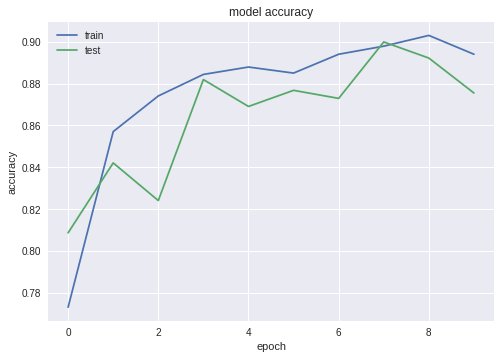

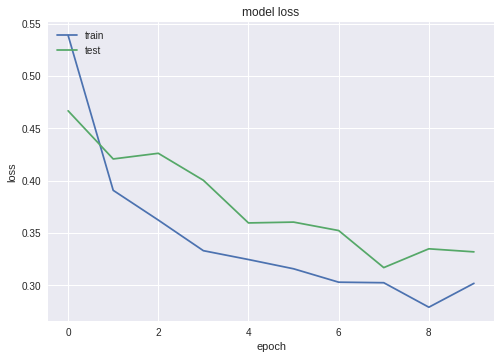

(None, None)

In [59]:
acc_plot(history_v1),loss_plot(history_v1)

### Modelv2

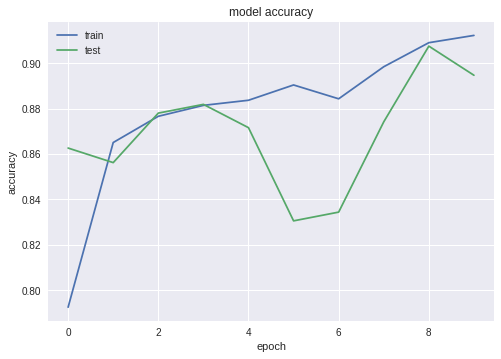

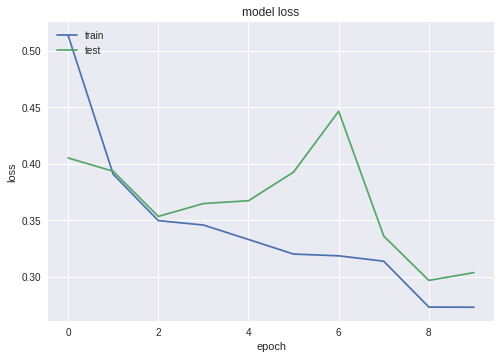

(None, None)

In [60]:
acc_plot(historyv2),loss_plot(historyv2)

### Modelv3

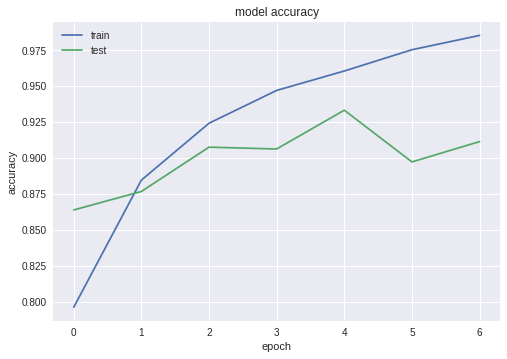

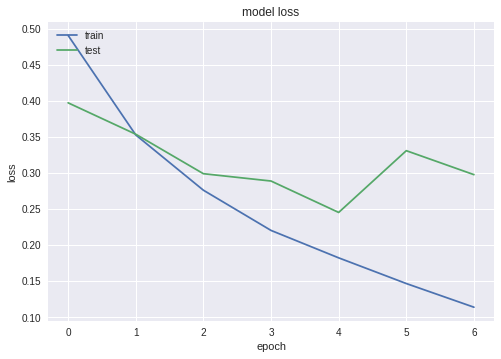

(None, None)

In [61]:
acc_plot(historyv3),loss_plot(historyv3)

### Modelv4

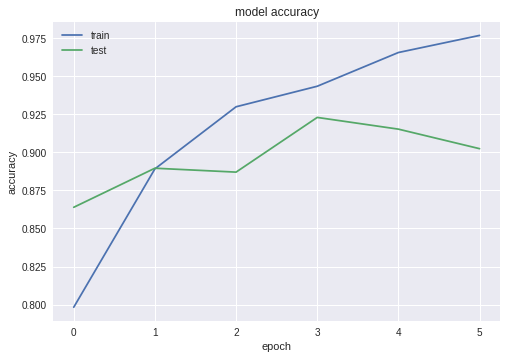

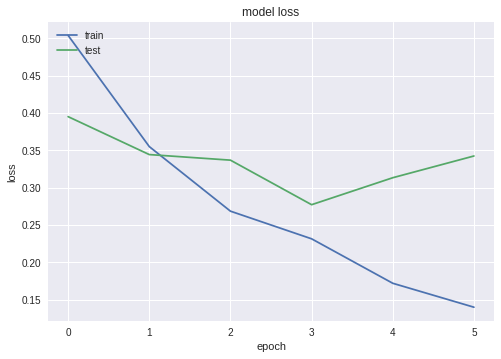

(None, None)

In [62]:
acc_plot(historyv4),loss_plot(historyv4)

In [0]:
def model_eval(msg, model,test_data,test_labels):
  print('Evaluation of: ',msg)
  dash_length = len('Evaluation of Model')
  print('---'*dash_length)
  y_Pred = model.predict(test_data)
  y_Pred = y_Pred[:,0] > 0.5
  y_Test = test_labels[:,0] > 0.5
  cm = confusion_matrix(y_Test, y_Pred)
  print(cm)
  print(classification_report(y_Test, y_Pred, target_names=['Real', 'Fake']))
  print('---'*dash_length)

In [64]:
model_eval('Modelv1',modelv1,xTest,yTest)
model_eval('Modelv2',modelv2,xTest,yTest)
model_eval('Modelv3',modelv3,xTest,yTest)
model_eval('Modelv4',modelv4,xTest,yTest)

Evaluation of:  Modelv1
---------------------------------------------------------
[[351  28]
 [ 69 331]]
              precision    recall  f1-score   support

        Real       0.84      0.93      0.88       379
        Fake       0.92      0.83      0.87       400

   micro avg       0.88      0.88      0.88       779
   macro avg       0.88      0.88      0.88       779
weighted avg       0.88      0.88      0.88       779

---------------------------------------------------------
Evaluation of:  Modelv2
---------------------------------------------------------
[[331  48]
 [ 34 366]]
              precision    recall  f1-score   support

        Real       0.91      0.87      0.89       379
        Fake       0.88      0.92      0.90       400

   micro avg       0.89      0.89      0.89       779
   macro avg       0.90      0.89      0.89       779
weighted avg       0.90      0.89      0.89       779

---------------------------------------------------------
Evaluation of:  Mode

# Generalization required.
Work needed to be done to improve model performance.